# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [ ]:
import os
import tqdm
import numpy as np
import torch
from torch import nn
import pandas as pd
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
from PIL import Image
from collections import Counter
from sklearn.metrics import roc_auc_score

In [ ]:
# Можно использовать, но балл за соответствующие задания будет снижен.
import pytorch_metric_learning.distances
import pytorch_metric_learning.samplers
import pytorch_metric_learning.losses

In [ ]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Чтобы каждый раз не закидывать зипку с трейнами и тестами вручную, я загурузил папки на гит и склонировал их.

In [ ]:
!git init dump
%cd dump

!git remote add -f origin https://github.com/Transmittance/dump.git

!git config core.sparseCheckout true
!git sparse-checkout set face_data

!git pull --depth=1 origin main

%cd /content

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/dump/.git/
/content/dump
Updating origin
remote: Enumerating objects: 1302, done.
remote: Counting objects: 100% (1302/1302), done.
remote: Compressing objects: 100% (1292/1292), done.
remote: Total 1302 (delta 19), reused 1293 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (1302/1302), 39.90 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (19/19), done.
From https://github.com/Transmittance/dump
 * [new branch]      main       -> origin/main
remote: Tot

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.RandomAffine(degrees=12, translate=(0.02, 0.02), scale=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

train_ds = torchvision.datasets.ImageFolder("/content/dump/face_data/training", transform = train_transform)
test_ds = torchvision.datasets.ImageFolder("/content/dump/face_data/testing", transform = test_transform)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

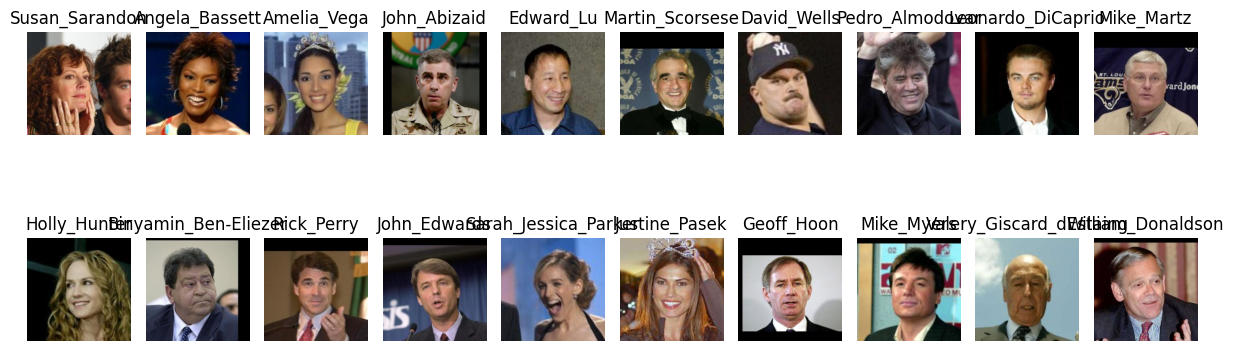

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(20):
    path, cls = random.choice(train_ds.samples)
    img = Image.open(path)
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.title(train_ds.classes[cls])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
len(train_ds)

1065

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

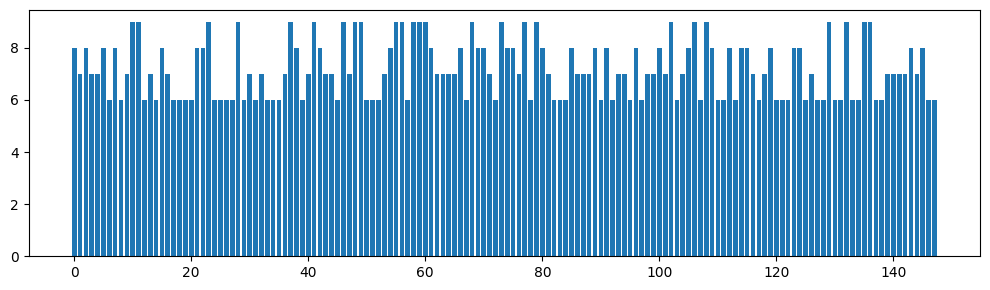

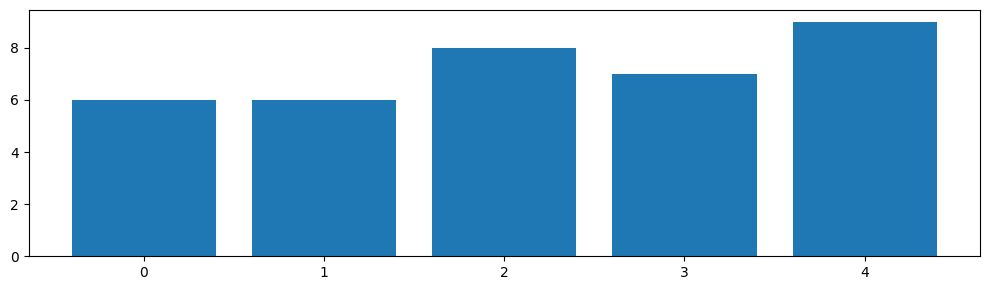

In [ ]:
def show_class_distribtion(targets):
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    targets = [int(t) for t in targets]

    counts = Counter(targets)
    values = list(counts.values())
    keys = list(counts.keys())

    plt.figure(figsize=(10, 3))
    plt.bar(keys, values)
    plt.tight_layout()
    plt.show()


show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 1359294.32it/s]


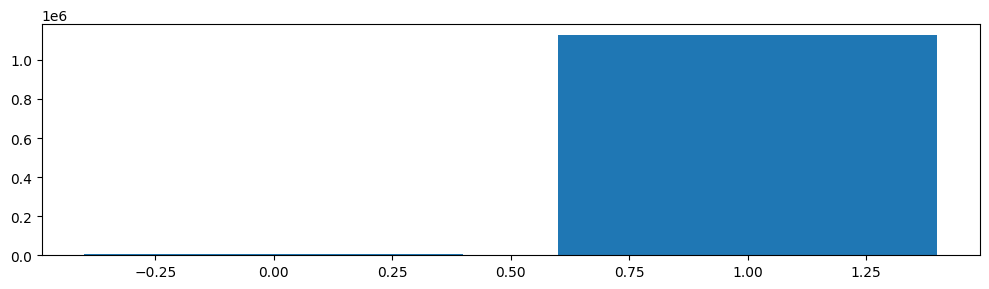

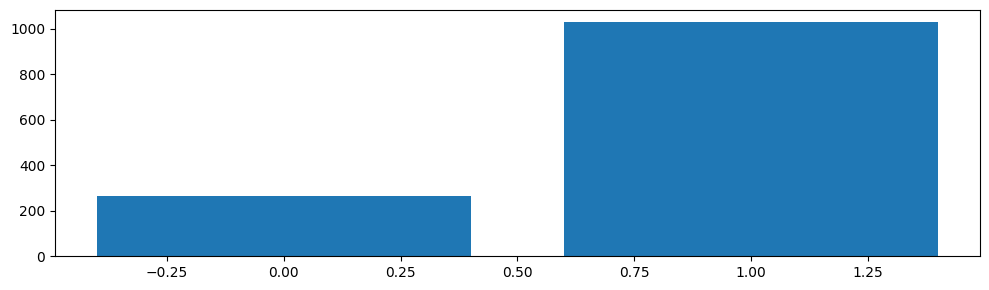

In [ ]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [ ]:
from torch.utils.data import Sampler

In [ ]:
class EqualClassesSampler(Sampler):
    def __init__(self, targets, seed=42):
        self.targets = targets
        self.seed = seed

        self.diff_ppl = [i for i, t in enumerate(targets) if t == 1]
        self.same_ppl = [i for i, t in enumerate(targets) if t == 0]

        self.min_length = min(len(self.diff_ppl), len(self.same_ppl))
        self.length = self.min_length * 2

    def __len__(self):
        return self.length

    def __iter__(self):
        rng = random.Random(self.seed)

        rng.shuffle(self.diff_ppl)
        rng.shuffle(self.same_ppl)

        for i in range(self.min_length):
            yield self.diff_ppl[i]
            yield self.same_ppl[i]

In [ ]:
train_pairs_sampler = EqualClassesSampler(train_pairs.targets)

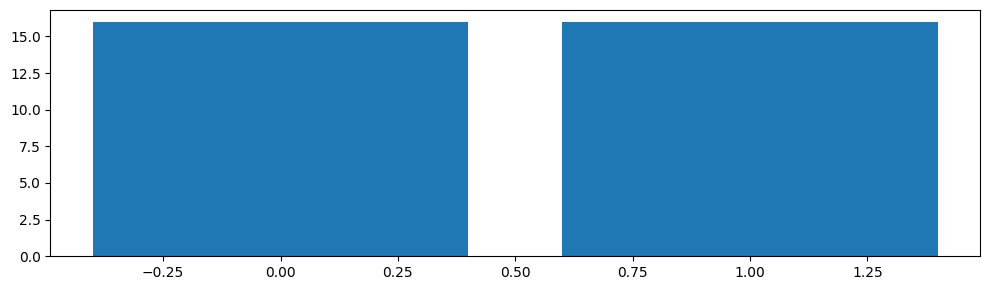

In [ ]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.
show_class_distribtion(next(iter(train_pairs_loader))[2])

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [ ]:
class ClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128,128,3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.embedding = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def encode(self, x):
        return self.embedding(self.model(x))

    def forward(self, image1, image2):
        image1_processed = self.encode(image1)
        image2_processed = self.encode(image2)
        features = torch.cat([torch.abs(image1_processed - image2_processed), image1_processed * image2_processed], dim=1)

        logit = self.classifier(features).squeeze(1)
        return logit

# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

Итак, из [источника](https://arxiv.org/html/2312.14001v2?utm_source=chatgpt.com) я узнал, что для данной задачи лучше использовать сиамскую сеть, где обе входные фотографии проходят через одинаковую сверточную сеть, которая выделяет ключевые признаки лица. Затем векторы признаков сравниваются: вычисляется их разность и произведение, после чего эти данные подаются в полносвязный классификатор, который выдаёт вероятность того, что на фотографиях один и тот же человек.

Архитектура представленной выше модели:

1) Свёрточная часть, которая доставёт из изображения признаки
* Свёрточный слой с 32 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(32)
* LeakyReLU(0.1)
* Свёрточный слой с 32 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(32)
* LeakyReLU(0.1)
* Max Pooling с ядром 2×2 и шагом 2

* Свёрточный слой с 64 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(64)
* LeakyReLU(0.1)
* Свёрточный слой с 64 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(64)
* LeakyReLU(0.1)
* Max Pooling с ядром 2×2 и шагом 2

* Свёрточный слой с 128 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(128)
* LeakyReLU(0.1)
* Свёрточный слой с 128 выходными каналами, ядром 3×3, паддингом 1
* BatchNorm2d(128)
* LeakyReLU(0.1)
* Adaptive Average Pooling до размера 1×1
* Flatten – преобразование тензора в вектор размерности 128

2) Блок, которые выдаёт эмбеддинги:
* Полносвязный слой (Linear) с 128 входами и 128 выходами
* Активация ReLU
* Dropout(p=0.2)

3) Классификатор:
* Полносвязный слой с 256 входами и 128 выходами и ReLU активация
* LeakyReLU(0.1)
* Dropout(p=0.2)
* Полносвязный слой с 128 входами и 1 выходом (логит для BCEWithLogitsLoss)

<hr>

Далее выяснилось, что моя модель оказалась не очень хороша (см. результаты в задании 2.2). Поэтому чтобы не получать низкий балл, я решил поменять модель. Вдохновившись моделью из семинара 3, получилась следующая модель:

In [ ]:
class ClassificationNetV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((16, 16))
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def encode(self, x):
        x = self.vgg(x)
        x = self.embedding(x)
        return x

    def forward(self, image1, image2):
        image1_processed = self.encode(image1)
        image2_processed = self.encode(image2)
        features = torch.cat([torch.abs(image1_processed - image2_processed), image1_processed * image2_processed], dim=1)

        logit = self.classifier(features).squeeze(1)
        return logit

assert ClassificationNetV2()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

Архитектура представленной выше модели:

1) Свёрточная часть, которая достаёт из изображения признаки
* Свёрточный слой с 16 выходными каналами, ядром 3×3, паддингом 1 и активацией ReLU
* Свёрточный слой с 16 выходными каналами, ядром 3×3, паддингом 1 и активацией ReLU
* Max Pooling с ядром 2×2 и шагом 2
* Adaptive Average Pooling до размера 16×16

2) Блок, который выдаёт эмбеддинги:
* Flatten – преобразование тензора в вектор размерности 16×16×16 = 4096
* Полносвязный слой (Linear) с 4096 входами и 128 выходами
* Активация ReLU
* Dropout(p=0.2)

3) Классификатор:
* Полносвязный слой (Linear) с 256 входами (так как на вход подаётся конкатенация |e1 − e2| и e1 * e2 имющая размерностт 256 (e1 и e2 это эмеббдинги изображения 1 и 2 соответственно)) и 128 выходами
* Активация ReLU
* Dropout(p=0.2)
* Полносвязный слой (Linear) с 128 входами и 1 выходом (логит для BCEWithLogitsLoss)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

***Пояснение:***

Снизу представлены юнифицированные функции для обучения модели. Их я взял из ДЗ1 и переделал для текущей задачи.

In [ ]:
def accuracy_metric(prediction, actual):
    return (prediction == actual).mean()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_status, device):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    model.train()
    total_loss = 0
    predictions = []
    actual = []

    loop = tqdm.tqdm(train_loader, desc=tqdm_status)
    for img1, img2, target in loop:
        img1, img2 = img1.to(device), img2.to(device)
        target = target.float().to(device)

        preds = model(img1, img2)
        loss = criterion(preds, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(preds).detach().cpu().numpy()
        preds_bin = (probs > 0.5).astype(int)
        targets_np = target.detach().cpu().numpy().astype(int)

        predictions.extend(preds_bin)
        actual.extend(targets_np)

        loop.set_postfix(loss=loss.item())

    loss = total_loss / len(train_loader)
    accuracy = accuracy_metric(np.array(predictions), np.array(actual))

    return loss, accuracy


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_status, device):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    model.eval()
    total_loss = 0
    predictions = []
    actual = []

    loop = tqdm.tqdm(val_loader, desc=tqdm_status)
    for img1, img2, target in loop:
        img1, img2 = img1.to(device), img2.to(device)
        target = target.float().to(device)

        preds = model(img1, img2)
        loss = criterion(preds, target)

        total_loss += loss.item()

        probs = torch.sigmoid(preds).cpu().numpy()
        preds_bin = (probs > 0.5).astype(int)
        targets_np = target.cpu().numpy().astype(int)

        predictions.extend(preds_bin)
        actual.extend(targets_np)

    loss = total_loss / len(val_loader)
    accuracy = accuracy_metric(np.array(predictions), np.array(actual))

    return loss, accuracy


@torch.no_grad()
def predict(model, data_loader, device):
    """ Предсказания модели
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        data_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    all_predictions = []

    for img1, img2, _ in data_loader:
        img1, img2 = img1.to(device), img2.to(device)
        preds = model(img1, img2)
        probs = torch.sigmoid(preds).cpu().numpy()
        all_predictions.extend(probs)

    predicts = torch.tensor(all_predictions, dtype=torch.float32)
    return predicts

def train(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_status=f'Training {epoch}/{epochs}',
            device=device
        )

        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader,
            tqdm_status=f'Validating {epoch}/{epochs}',
            device=device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train accuracy: {train_accuracy:.4f}, Val accuracy: {val_accuracy:.4f}')

    return train_accuracies, val_accuracies, train_losses, val_losses

***Пояснение:***

Мне нужна валидационная выборка. Но в процессе выполнения задания мы её не создали. Поэтому мне пришлось сделать её самому, конечно, соблюдая фиксацию random_seed, чтобы Вы, проверяющий, смогли всё воспроизвести. Валидационная выборка получена путём разделения текущей обучающей выборки на обучающую и валидационную в пропорции 80/20 процентов. Потом выяснилось, что валидация занимает очень много времени. Поэтому мне пришлось сократить валиадционную выборку.

In [ ]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_pairs))
train_size = len(train_pairs) - val_size

train_subset, val_subset = random_split(train_pairs, [train_size, val_size], generator=torch.Generator().manual_seed(42))

subset_targets = [train_pairs.targets[i] for i in train_subset.indices]
train_pairs_sampler = EqualClassesSampler(subset_targets)

rng = np.random.RandomState(42)
val_count = min(5000, len(val_subset))
val_indices = rng.choice(len(val_subset), size=val_count, replace=False)
val_small = torch.utils.data.Subset(val_subset, val_indices)

train_pairs_loader_new = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=train_pairs_sampler)
val_pairs_loader = torch.utils.data.DataLoader(val_small, batch_size=256, shuffle=False)

In [ ]:
model = ClassificationNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0011)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))

In [ ]:
set_random_seed()
train_accuracies, val_accuracies, train_losses, val_losses = train(model, optimizer, criterion, train_pairs_loader_new, val_pairs_loader, epochs=10, device=device)

Validating 1/10: 100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


Epoch 1: Train Loss: 0.6846, Val Loss: 0.7061, Train accuracy: 0.5526, Val accuracy: 0.4458


Validating 2/10: 100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


Epoch 2: Train Loss: 0.6792, Val Loss: 0.7256, Train accuracy: 0.5700, Val accuracy: 0.5204


Validating 3/10: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


Epoch 3: Train Loss: 0.6768, Val Loss: 0.7444, Train accuracy: 0.5770, Val accuracy: 0.4838


Validating 4/10: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


Epoch 4: Train Loss: 0.6733, Val Loss: 0.7197, Train accuracy: 0.5829, Val accuracy: 0.5714


Validating 5/10: 100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


Epoch 5: Train Loss: 0.6759, Val Loss: 0.7107, Train accuracy: 0.5752, Val accuracy: 0.5770


Validating 6/10: 100%|██████████| 20/20 [01:00<00:00,  3.00s/it]


Epoch 6: Train Loss: 0.6714, Val Loss: 0.7314, Train accuracy: 0.5807, Val accuracy: 0.5542


Validating 7/10: 100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


Epoch 7: Train Loss: 0.6662, Val Loss: 0.6997, Train accuracy: 0.5918, Val accuracy: 0.6568


Validating 8/10: 100%|██████████| 20/20 [01:02<00:00,  3.10s/it]


Epoch 8: Train Loss: 0.6645, Val Loss: 0.7430, Train accuracy: 0.5955, Val accuracy: 0.6026


Validating 9/10: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


Epoch 9: Train Loss: 0.6625, Val Loss: 0.7191, Train accuracy: 0.5901, Val accuracy: 0.6114


Validating 10/10: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]

Epoch 10: Train Loss: 0.6604, Val Loss: 0.6981, Train accuracy: 0.5979, Val accuracy: 0.7000


In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)

    print(f"Мой AUC-ROC: {sklearn.metrics.roc_auc_score(targets, preds)}")
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 21/21 [00:12<00:00,  1.65it/s]

Мой AUC-ROC: 0.6432732316227463


np.float64(0.540915395284329)

Как можно заметить, получились не очень хорошие результаты. AUC-ROC для `ClassificationNet` вышло всего лишь `0.6432`. Поэтому далее будет обучение модели `ClassificationNetV2` на тех же данных. Данная модель описана в пункте 2.1 этогй домашки.

In [ ]:
model = ClassificationNetV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))

In [ ]:
set_random_seed()
train_accuracies, val_accuracies, train_losses, val_losses = train(model, optimizer, criterion, train_pairs_loader_new, val_pairs_loader, epochs=20, device=device)

Validating 1/20: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Epoch 1: Train Loss: 0.6753, Val Loss: 0.7587, Train accuracy: 0.5783, Val accuracy: 0.4342


Validating 2/20: 100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


Epoch 2: Train Loss: 0.6366, Val Loss: 0.6979, Train accuracy: 0.6394, Val accuracy: 0.5596


Validating 3/20: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Epoch 3: Train Loss: 0.6054, Val Loss: 0.6357, Train accuracy: 0.6688, Val accuracy: 0.6086


Validating 4/20: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Epoch 4: Train Loss: 0.5727, Val Loss: 0.6600, Train accuracy: 0.6981, Val accuracy: 0.6086


Validating 5/20: 100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


Epoch 5: Train Loss: 0.5581, Val Loss: 0.6133, Train accuracy: 0.7070, Val accuracy: 0.6378


Validating 6/20: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Epoch 6: Train Loss: 0.5367, Val Loss: 0.5695, Train accuracy: 0.7253, Val accuracy: 0.6738


Validating 7/20: 100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Epoch 7: Train Loss: 0.5125, Val Loss: 0.6313, Train accuracy: 0.7435, Val accuracy: 0.6116


Validating 8/20: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Epoch 8: Train Loss: 0.5071, Val Loss: 0.5836, Train accuracy: 0.7494, Val accuracy: 0.6652


Validating 9/20: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Epoch 9: Train Loss: 0.4962, Val Loss: 0.5443, Train accuracy: 0.7486, Val accuracy: 0.6854


Validating 10/20: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Epoch 10: Train Loss: 0.4790, Val Loss: 0.6509, Train accuracy: 0.7629, Val accuracy: 0.6096


Validating 11/20: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Epoch 11: Train Loss: 0.4665, Val Loss: 0.5161, Train accuracy: 0.7711, Val accuracy: 0.7232


Validating 12/20: 100%|██████████| 20/20 [00:49<00:00,  2.45s/it]


Epoch 12: Train Loss: 0.4648, Val Loss: 0.5415, Train accuracy: 0.7779, Val accuracy: 0.6910


Validating 13/20: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


Epoch 13: Train Loss: 0.4539, Val Loss: 0.5539, Train accuracy: 0.7824, Val accuracy: 0.6874


Validating 14/20: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Epoch 14: Train Loss: 0.4384, Val Loss: 0.4736, Train accuracy: 0.7906, Val accuracy: 0.7406


Validating 15/20: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Epoch 15: Train Loss: 0.4375, Val Loss: 0.5042, Train accuracy: 0.7940, Val accuracy: 0.7248


Validating 16/20: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Epoch 16: Train Loss: 0.4292, Val Loss: 0.5077, Train accuracy: 0.8017, Val accuracy: 0.7268


Validating 17/20: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Epoch 17: Train Loss: 0.4263, Val Loss: 0.4429, Train accuracy: 0.8003, Val accuracy: 0.7490


Validating 18/20: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Epoch 18: Train Loss: 0.4186, Val Loss: 0.4898, Train accuracy: 0.8034, Val accuracy: 0.7070


Validating 19/20: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


Epoch 19: Train Loss: 0.4170, Val Loss: 0.4431, Train accuracy: 0.8054, Val accuracy: 0.7562


Validating 20/20: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]

Epoch 20: Train Loss: 0.4104, Val Loss: 0.5103, Train accuracy: 0.8101, Val accuracy: 0.7074


In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)

    print(f"\nМой AUC-ROC: {sklearn.metrics.roc_auc_score(targets, preds)}")
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Мой AUC-ROC: 0.9621286225271919


2.5

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

<hr>

***Анализ:***

Первая моя модель, `ClassificationNet` получила AUC-ROC score равным `0.6432`. После того, как я поменял структуру модели, `ClassificationNetV2`, обученная на тех же данных дала AUC-ROC score – `0.962`. Конечно хороший результат, но всё же – решать задачу определения принадлежности лиц одному и тому же человеку через через бинарную классификацию – не лучшая идея. И вот почему:
- При бинарной классификации модель учится различать только те пары людей, которые видела во время обучения. Еслипопадётся новое лицо, то качестов будет плохим. А `triplet loss` должен решить эту проблему.
- После балансировки классов количество доступных пар становится значительно меньше, чем могло бы быть. При обучении с `triplet loss` можно использовать гораздо больше комбинаций.
- Бинарная модель не формирует вектор признаков для каждого лица — она просто выдаёт 0 или 1 для пары. А `triplet loss` работает с веткорами.

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [ ]:
def triplet_loss(embeddings, labels, margin):
    emb = torch.nn.functional.normalize(embeddings, dim=1)
    labels = labels.long()
    dist = torch.cdist(emb, emb, p=2)

    loss = 0.0
    triplets = 0

    for i in range(len(labels)):
        pos_mask = (labels == labels[i])
        neg_mask = (labels != labels[i])

        pos_dist = dist[i][pos_mask]
        neg_dist = dist[i][neg_mask]
        pos_dist = pos_dist[pos_dist > 0]

        if pos_dist.numel() == 0 or neg_dist.numel() == 0:
            continue

        diff = pos_dist.unsqueeze(1) - neg_dist.unsqueeze(0) + margin
        tl = torch.relu(diff)
        mask = tl > 0
        if mask.any():
            loss += tl[mask].mean()
            triplets += 1

    if triplets == 0:
        return torch.tensor(0.0, requires_grad=True, device=embeddings.device)
    return loss / triplets


In [ ]:
criterion = lambda emb, y: triplet_loss(emb, y, margin=0.25)

In [ ]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

Изменим код для обучения:

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_status, device):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    model.train()
    total_loss = 0

    loop = tqdm.tqdm(train_loader, desc=tqdm_status)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.long().to(device)

        embeddings = model.encode(images)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    loss = total_loss / len(train_loader)

    return loss


@torch.no_grad()
def validation_epoch(model, val_loader, tqdm_status, device):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    model.eval()
    total_loss = 0
    scores = []
    actual = []

    loop = tqdm.tqdm(val_loader, desc=tqdm_status)
    for img1, img2, target in loop:
        img1, img2 = img1.to(device), img2.to(device)
        target = target.cpu().numpy()

        e1 = torch.nn.functional.normalize(model.encode(img1), dim=1)
        e2 = torch.nn.functional.normalize(model.encode(img2), dim=1)
        simmilarity = (e1 * e2).sum(dim=1).cpu().numpy()

        scores.extend(simmilarity)
        actual.extend(target)

    # try:
    #     val_auc = roc_auc_score(actual, scores)
    # except ValueError:
    #     val_auc = 0.0

    return 0., 0.


@torch.no_grad()
def predict(model, data_loader, device):
    """ Предсказания модели
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        data_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    all_predictions = []

    for img1, img2, _ in data_loader:
        img1, img2 = img1.to(device), img2.to(device)

        e1 = torch.nn.functional.normalize(model.encode(img1), dim=1)
        e2 = torch.nn.functional.normalize(model.encode(img2), dim=1)

        simmilarity = (e1 * e2).sum(dim=1)

        probs = torch.sigmoid(simmilarity).cpu().numpy()
        all_predictions.extend(probs)

    predicts = torch.tensor(all_predictions, dtype=torch.float32)
    return predicts

def train(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """

    train_losses, val_aucs = [], []

    for epoch in range(1, epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_status=f'Training {epoch}/{epochs}',
            device=device
        )

        # _, val_auc = validation_epoch(
        #     model, val_loader,
        #     tqdm_status=f'Validating {epoch}/{epochs}',
        #     device=device
        # )

        train_losses.append(train_loss)
        # val_aucs.append(val_auc)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}")

    return train_losses, val_aucs

Далее нужен новый лоадер. Напишем его:

In [ ]:
from collections import defaultdict

class PKSampler(Sampler):
    def __init__(self, labels, P=16, K=4, seed=42):
        self.labels = np.asarray(labels)
        self.P, self.K = P, K
        self.rng = random.Random(seed)

        self.by_class = defaultdict(list)
        for idx, c in enumerate(self.labels):
            self.by_class[int(c)].append(idx)
        self.classes = list(self.by_class.keys())

        self.length = (len(self.classes) // P) * (P * K)

    def __len__(self):
        return self.length

    def __iter__(self):
        classes = self.classes[:]
        self.rng.shuffle(classes)
        for i in range(0, len(classes) - self.P + 1, self.P):
            chunk = classes[i:i+self.P]
            for c in chunk:
                pool = self.by_class[c]
                if len(pool) >= self.K:
                    picks = self.rng.sample(pool, self.K)
                else:
                    picks = [self.rng.choice(pool) for _ in range(self.K)]
                for p in picks:
                    yield p


In [ ]:
P, K = 12, 6
pk_sampler = PKSampler(train_ds.targets, P=P, K=K, seed=42)

train_id_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=P*K,
    sampler=pk_sampler,
    num_workers=2,
    pin_memory=True
)

In [ ]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_pairs))
train_size = len(train_pairs) - val_size

train_subset, val_subset = random_split(train_pairs, [train_size, val_size], generator=torch.Generator().manual_seed(42))

subset_targets = [train_pairs.targets[i] for i in train_subset.indices]
train_pairs_sampler = EqualClassesSampler(subset_targets)

rng = np.random.RandomState(42)
val_count = min(1, len(val_subset))
val_indices = rng.choice(len(val_subset), size=val_count, replace=False)
val_small = torch.utils.data.Subset(val_subset, val_indices)

train_pairs_loader_new = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=train_pairs_sampler)
val_pairs_loader = torch.utils.data.DataLoader(val_small, batch_size=256, shuffle=False)

In [ ]:
model = ClassificationNetV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = lambda emb, y: triplet_loss(emb, y, margin=0.24)

In [ ]:
set_random_seed()
train_losses, val_aucs = train(model, optimizer, criterion, train_id_loader, val_pairs_loader, epochs=25, device=device)

Training 1/25: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s, loss=0.248]


Epoch 1: Train Loss: 0.2468


Training 2/25: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s, loss=0.247]


Epoch 2: Train Loss: 0.2367


Training 3/25: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s, loss=0.224]


Epoch 3: Train Loss: 0.2416


Training 4/25: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s, loss=0.259]


Epoch 4: Train Loss: 0.2374


Training 5/25: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s, loss=0.24]


Epoch 5: Train Loss: 0.2415


Training 6/25: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s, loss=0.258]


Epoch 6: Train Loss: 0.2386


Training 7/25: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s, loss=0.221]


Epoch 7: Train Loss: 0.2313


Training 8/25: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s, loss=0.221]


Epoch 8: Train Loss: 0.2316


Training 9/25: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s, loss=0.235]


Epoch 9: Train Loss: 0.2400


Training 10/25: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.237]


Epoch 10: Train Loss: 0.2368


Training 11/25: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s, loss=0.201]


Epoch 11: Train Loss: 0.2318


Training 12/25: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s, loss=0.232]


Epoch 12: Train Loss: 0.2340


Training 13/25: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s, loss=0.231]


Epoch 13: Train Loss: 0.2358


Training 14/25: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s, loss=0.243]


Epoch 14: Train Loss: 0.2352


Training 15/25: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, loss=0.224]


Epoch 15: Train Loss: 0.2347


Training 16/25: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s, loss=0.217]


Epoch 16: Train Loss: 0.2338


Training 17/25: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s, loss=0.219]


Epoch 17: Train Loss: 0.2345


Training 18/25: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s, loss=0.231]


Epoch 18: Train Loss: 0.2268


Training 19/25: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s, loss=0.227]


Epoch 19: Train Loss: 0.2204


Training 20/25: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, loss=0.228]


Epoch 20: Train Loss: 0.2264


Training 21/25: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s, loss=0.225]


Epoch 21: Train Loss: 0.2267


Training 22/25: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.202]


Epoch 22: Train Loss: 0.2187


Training 23/25: 100%|██████████| 12/12 [00:08<00:00,  1.39it/s, loss=0.212]


Epoch 23: Train Loss: 0.2292


Training 24/25: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s, loss=0.228]


Epoch 24: Train Loss: 0.2248


Training 25/25: 100%|██████████| 12/12 [00:05<00:00,  2.40it/s, loss=0.206]

Epoch 25: Train Loss: 0.2213


In [ ]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = torch.nn.functional.normalize(model.encode(images1.to(device)), dim=1)
            emb2 = torch.nn.functional.normalize(model.encode(images2.to(device)), dim=1)
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    print(f"\nМой AUC-ROC: {sklearn.metrics.roc_auc_score(targets, preds)}")
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 21/21 [00:05<00:00,  3.53it/s]


Мой AUC-ROC: 0.9527848748083801


3

<hr>

***Анализ:***

Модель с `triplet loss` справляется гораздо лучше, чем простоая бинарная классификация, даже не смотря на то, что `AUC ROC` у них примерно одинаковый. `AUC ROC` с `triplet loss` получился `0.95`!

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [ ]:
# Set environment variable to potentially help with CUDA out of memory errors
device = torch.device("cpu")

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

my_img1 = Image.open("/content/1.png").convert("RGB")
my_tensor1 = test_transform(my_img1)
my_img2 = Image.open("/content/2.png").convert("RGB")
my_tensor2 = test_transform(my_img2)

celeb_ds = torchvision.datasets.ImageFolder("/content/dump/face_data/training", transform=test_transform)
idx_to_class = {v: k for k, v in celeb_ds.class_to_idx.items()}

class Pairs(torch.utils.data.Dataset):
    def __init__(self, left_tensor, right_ds):
        self.left = left_tensor
        self.right_ds = right_ds
    def __len__(self): return len(self.right_ds)
    def __getitem__(self, idx):
        right_img, _ = self.right_ds[idx]
        return self.left, right_img, torch.tensor(0.0)

pair_loader1 = torch.utils.data.DataLoader(
    Pairs(my_tensor1, celeb_ds),
    batch_size=128, shuffle=False
)

scores1 = predict(model, pair_loader1, device).numpy()
labels1 = np.array(celeb_ds.targets)

unique_labels1 = np.unique(labels1)
class_best1 = {c: float(scores1[labels1 == c].max()) for c in unique_labels1}
top1 = sorted(class_best1.items(), key=lambda x: x[1], reverse=True)[:5]

pair_loader2 = torch.utils.data.DataLoader(
    Pairs(my_tensor2, celeb_ds),
    batch_size=128, shuffle=False
)

scores2 = predict(model, pair_loader2, device).numpy()
labels2 = np.array(celeb_ds.targets)

unique_labels2 = np.unique(labels2)
class_best2 = {c: float(scores2[labels2 == c].max()) for c in unique_labels2}
top2 = sorted(class_best2.items(), key=lambda x: x[1], reverse=True)[:5]

fig, axs = plt.subplots(2, 6, figsize=(18, 8))

axs[0, 0].imshow(my_img1)
axs[0, 0].set_title("My photo 1")
axs[0, 0].axis("off")

for i, (c, p) in enumerate(top1, 1):
    mask = (labels1 == c)
    best_local = np.argmax(scores1[mask])
    best_global = np.where(mask)[0][best_local]
    best_path = celeb_ds.samples[best_global][0]
    celeb_img = Image.open(best_path).convert("RGB")
    axs[0, i].imshow(celeb_img)
    axs[0, i].set_title(f"{idx_to_class[c]}  {p*100:.1f}%")
    axs[0, i].axis("off")

axs[1, 0].imshow(my_img2)
axs[1, 0].set_title("My photo 2")
axs[1, 0].axis("off")

for i, (c, p) in enumerate(top2, 1):
    mask = (labels2 == c)
    best_local = np.argmax(scores2[mask])
    best_global = np.where(mask)[0][best_local]
    best_path = celeb_ds.samples[best_global][0]
    celeb_img = Image.open(best_path).convert("RGB")
    axs[1, i].imshow(celeb_img)
    axs[1, i].set_title(f"{idx_to_class[c]}  {p*100:.1f}%")
    axs[1, i].axis("off")

fig.suptitle("Top-5 celebrities for each of my photos", fontsize=16)
plt.tight_layout()
plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor